In [2]:
!pip install seaborn

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Random Forest").getOrCreate()

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dados com distribuição normal
np.random.seed(42)
dados_normais = pd.DataFrame({
    "cilindradas": np.random.normal(loc=1.6, scale=0.3, size=100),
    "peso": np.random.normal(loc=1100, scale=150, size=100),
    "potencia": np.random.normal(loc=110, scale=20, size=100),
    "consumo_kml": np.random.normal(loc=13, scale=1.5, size=100)
})

# Dados com distribuição assimétrica
dados_assimetricos = pd.DataFrame({
    "cilindradas": np.random.exponential(scale=0.5, size=100) + 1.0,
    "peso": np.random.exponential(scale=200, size=100) + 800,
    "potencia": np.random.exponential(scale=30, size=100) + 70,
    "consumo_kml": np.random.exponential(scale=2, size=100) + 10
})

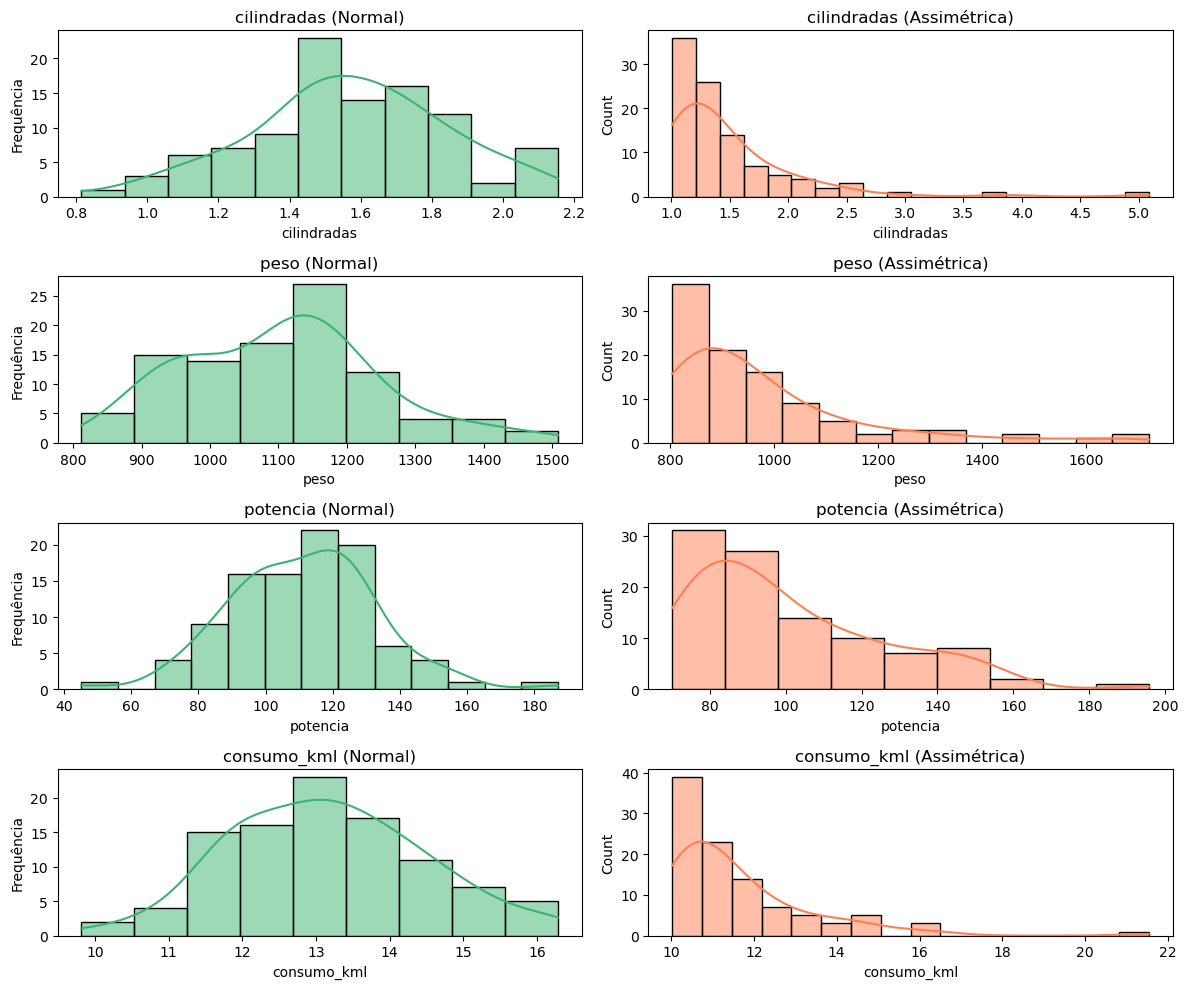

In [5]:
variaveis = ["cilindradas", "peso", "potencia", "consumo_kml"]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))

for i, var in enumerate(variaveis):
    # Distribuição normal
    sns.histplot(dados_normais[var], kde=True, ax=axes[i, 0], color='mediumseagreen')
    axes[i, 0].set_title(f'{var} (Normal)')
    axes[i, 0].set_ylabel("Frequência")

    # Distribuição assimétrica
    sns.histplot(dados_assimetricos[var], kde=True, ax=axes[i, 1], color='coral')
    axes[i, 1].set_title(f'{var} (Assimétrica)')

plt.tight_layout()
plt.show()

In [3]:
dados = spark.createDataFrame([
    (1.0, 900, 75, 15.2),     # motor pequeno, leve, econômico
    (1.6, 1100, 110, 13.0),   # intermediário
    (2.0, 1300, 140, 11.5),   # mais pesado e potente
    (1.4, 1050, 100, 13.5),
    (1.0, 950, 80, 15.0),
    (2.2, 1400, 160, 10.2),   # motorzão
    (1.8, 1250, 130, 12.1),
    (1.2, 1000, 90, 14.2)
], ["cilindradas", "peso", "potencia", "consumo_kml"])

dados.show()

+-----------+----+--------+-----------+
|cilindradas|peso|potencia|consumo_kml|
+-----------+----+--------+-----------+
|        1.0| 900|      75|       15.2|
|        1.6|1100|     110|       13.0|
|        2.0|1300|     140|       11.5|
|        1.4|1050|     100|       13.5|
|        1.0| 950|      80|       15.0|
|        2.2|1400|     160|       10.2|
|        1.8|1250|     130|       12.1|
|        1.2|1000|      90|       14.2|
+-----------+----+--------+-----------+



In [6]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["cilindradas", "peso", "potencia"],
    outputCol="features"
)
dados_vet = assembler.transform(dados).select("features", "consumo_kml")

In [8]:
dados_vet.show(5)

+------------------+-----------+
|          features|consumo_kml|
+------------------+-----------+
|  [1.0,900.0,75.0]|       15.2|
|[1.6,1100.0,110.0]|       13.0|
|[2.0,1300.0,140.0]|       11.5|
|[1.4,1050.0,100.0]|       13.5|
|  [1.0,950.0,80.0]|       15.0|
+------------------+-----------+
only showing top 5 rows



In [17]:
treino, teste= dados_vet.randomSplit([0.5,0.5],seed=42)

In [18]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="consumo_kml", numTrees=60, maxDepth=10, seed=42)
modelo_rf = rf.fit(treino)

In [19]:
previsoes = modelo_rf.transform(teste)

In [20]:
previsoes.select("features", "consumo_kml", "prediction").show(truncate=False)

+------------------+-----------+------------------+
|features          |consumo_kml|prediction        |
+------------------+-----------+------------------+
|[1.0,900.0,75.0]  |15.2       |13.080000000000004|
|[1.6,1100.0,110.0]|13.0       |11.995000000000006|
|[1.4,1050.0,100.0]|13.5       |13.080000000000004|
|[2.2,1400.0,160.0]|10.2       |11.125000000000002|
|[1.2,1000.0,90.0] |14.2       |13.080000000000004|
+------------------+-----------+------------------+



In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
rmse = RegressionEvaluator(labelCol="consumo_kml", predictionCol="prediction", metricName="rmse").evaluate(previsoes)

In [23]:
r2 = RegressionEvaluator(labelCol="consumo_kml", predictionCol="prediction", metricName="r2").evaluate(previsoes)

In [24]:
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 1.25
R²: 0.45


RMSE => Root Mean Squared 
R2 => MEde o qual bom o modelo explica a variancia dos dados. -Infinito a 1